In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [25]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [115]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / ((n_embd * block_size)**0.5))
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12124


tensor(0.0259) tensor(1.0066)
tensor(0.0015) tensor(0.9942)


(array([9.02540210e-05, 0.00000000e+00, 1.12817526e-04, 1.35381032e-04,
        4.06143095e-04, 4.51270105e-04, 9.25103716e-04, 1.17330227e-03,
        2.12096949e-03, 3.58759734e-03, 4.91884415e-03, 8.66438602e-03,
        1.20489118e-02, 1.99687022e-02, 3.07766212e-02, 4.47434309e-02,
        7.25416694e-02, 9.96855662e-02, 1.44993085e-01, 2.00770070e-01,
        2.54268141e-01, 3.17445956e-01, 3.75321347e-01, 4.15913092e-01,
        4.30647061e-01, 4.19884269e-01, 3.78886380e-01, 3.23876555e-01,
        2.64376591e-01, 2.06546327e-01, 1.51175485e-01, 1.09748890e-01,
        7.35570272e-02, 4.96397116e-02, 3.41837105e-02, 2.18640366e-02,
        1.39442463e-02, 9.04796561e-03, 5.66343982e-03, 3.22658125e-03,
        2.12096949e-03, 1.35381032e-03, 8.57413200e-04, 3.83579589e-04,
        2.70762063e-04, 1.80508042e-04, 1.12817526e-04, 2.25635053e-05,
        4.51270105e-05, 2.25635053e-05]),
 array([-5.44488144, -5.22328466, -5.00168789, -4.78009111, -4.55849434,
        -4.33689756, 

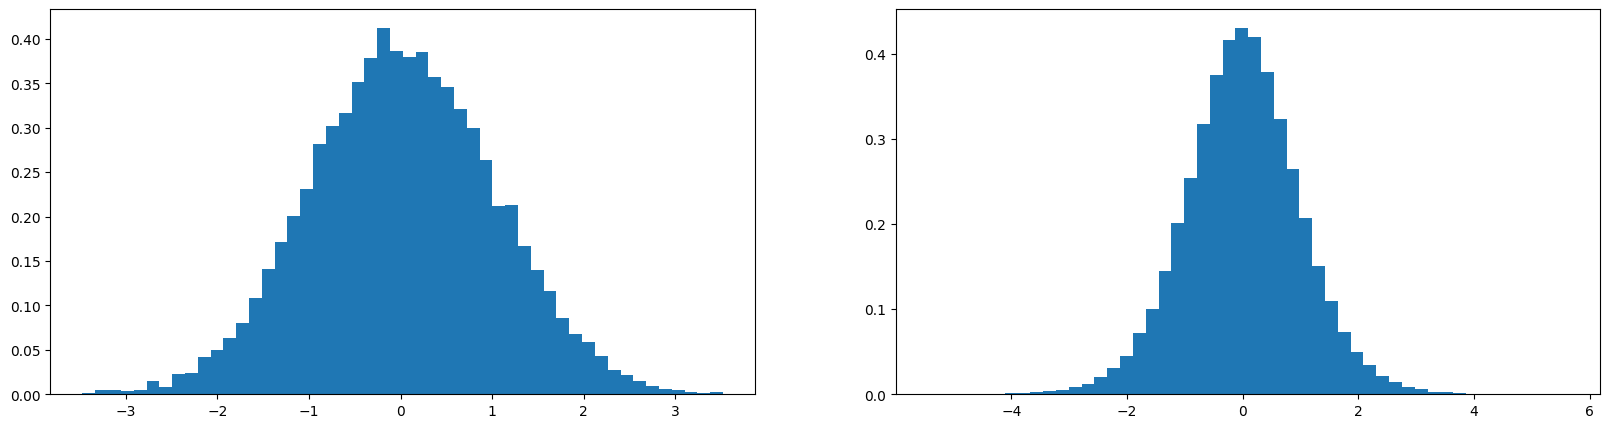

In [92]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)


In [116]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.0001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



      0/ 200000: 3.3014
  10000/ 200000: 2.4865
  20000/ 200000: 2.3281
  30000/ 200000: 2.0889
  40000/ 200000: 2.0617
  50000/ 200000: 2.4166
  60000/ 200000: 2.2835
  70000/ 200000: 2.0891
  80000/ 200000: 2.0070
  90000/ 200000: 2.0433
 100000/ 200000: 2.4734
 110000/ 200000: 2.1992
 120000/ 200000: 2.1248
 130000/ 200000: 2.4381
 140000/ 200000: 2.3030
 150000/ 200000: 2.3073
 160000/ 200000: 2.0962
 170000/ 200000: 2.0224
 180000/ 200000: 2.3781
 190000/ 200000: 1.9339


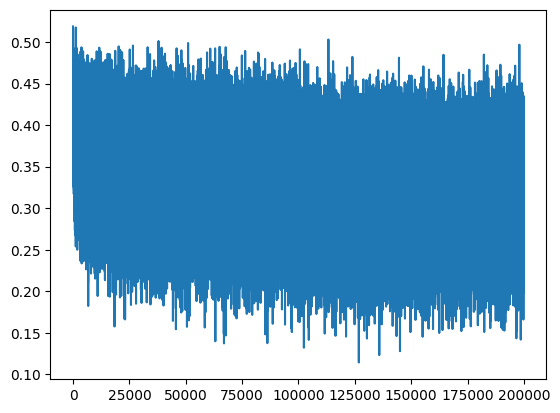

In [106]:
plt.plot(lossi)

In [117]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [118]:
bnmean

tensor([[-2.0895,  0.4795, -0.8454,  1.3410,  0.8249,  0.4330,  1.9284, -1.3172,
          1.2212,  1.1588, -2.7461, -1.8130, -0.8978, -1.0157, -0.6060, -0.6028,
          0.8007, -1.9635, -0.4728,  1.8451, -0.6382, -0.0481, -0.3228,  0.3833,
          1.0423,  1.8112,  1.4931, -0.0326,  0.8324,  1.5424, -0.4149, -1.2536,
          0.6878,  0.1554,  0.6909, -1.0393, -2.5005,  0.4790,  0.1478,  0.9354,
         -0.2237, -0.9314, -0.5359, -0.0978,  1.0885,  0.1454,  0.5929, -1.7371,
          1.5033,  1.0246,  1.1082,  0.1363,  1.9423,  0.5659,  1.3696, -2.4978,
         -0.2588,  0.2964,  2.6246, -2.0218, -0.3824,  0.7694,  0.5086,  0.1863,
          0.9806,  1.0028, -0.6537,  1.4902, -0.4953, -0.6671,  0.1242,  0.6717,
          0.5229, -1.5786, -2.0664,  0.1981,  1.0723,  0.5648,  0.5885,  0.4968,
         -0.0762,  1.4608,  1.2702,  1.0625,  0.4097, -0.6694, -0.9315, -0.0910,
          0.0806, -0.0356, -0.7488,  1.0149, -1.0048, -0.9880, -2.0145,  0.7548,
         -0.4409, -0.2996, -

In [119]:
bnmean_running

tensor([[-0.2075,  0.0477, -0.0859,  0.1347,  0.0825,  0.0432,  0.1940, -0.1298,
          0.1220,  0.1174, -0.2721, -0.1809, -0.0882, -0.1025, -0.0589, -0.0601,
          0.0788, -0.1980, -0.0462,  0.1839, -0.0625, -0.0037, -0.0324,  0.0377,
          0.1039,  0.1813,  0.1494, -0.0036,  0.0832,  0.1550, -0.0416, -0.1259,
          0.0689,  0.0161,  0.0673, -0.1029, -0.2492,  0.0498,  0.0137,  0.0929,
         -0.0211, -0.0912, -0.0551, -0.0083,  0.1075,  0.0130,  0.0597, -0.1733,
          0.1509,  0.1037,  0.1102,  0.0136,  0.1951,  0.0584,  0.1363, -0.2477,
         -0.0251,  0.0294,  0.2605, -0.2019, -0.0382,  0.0770,  0.0514,  0.0211,
          0.0985,  0.1009, -0.0649,  0.1488, -0.0495, -0.0670,  0.0117,  0.0648,
          0.0544, -0.1588, -0.2058,  0.0195,  0.1055,  0.0557,  0.0587,  0.0499,
         -0.0074,  0.1462,  0.1283,  0.1048,  0.0400, -0.0691, -0.0935, -0.0090,
          0.0087, -0.0048, -0.0762,  0.1008, -0.0990, -0.0975, -0.2005,  0.0768,
         -0.0441, -0.0291, -

In [113]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

  h = torch.tanh(hpreact) # (N, n_hidden)

  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0659077167510986
val 2.110661029815674


In [121]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    # context[2] = 1
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()

      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

trezlardghturisharshannerizirillassrllask.
khnna.
stacyphbrtthrightzi.
solissanvord.
stedngraclynnessdel.
triverriofsbsp.
hunishavtrllassinsled.
sabrlnguswairannishannissazellder.
sadrithrishanshidbsrathrishslqelissannysahhrreznnemarisslmishvaysobis.
sosslbiljanayelghtlsceffernssimellebhsleymaszisammigamrismansissarrschllsahmifanverissasslannensleya.
sanniffoystafisasdawrnsthusshfrgbriannalissuststoffirratobiddopknnyssshfard.
tragstou.
jughthryslannelrylmbierrispnytayvannishingsstrymerphnelfatirskippedrszyah.
juznlez.
brtus.
briornichlkismbassiendorasmbreightsbarneferriemarlyssadrysassrennehllssintalshynndishiswaturzcansodndsluscaddie.
zhmihnnequonz.
trendss.
trysssbrissasslyahshannersshnnezsraagatzicolcarlissndracinsluwhtsn.
samarladnsamillisanfaylianolill.


In [134]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [135]:
# same optimization as last time
max_steps = 80000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


      0/  80000: 3.3313
  10000/  80000: 2.2837
  20000/  80000: 2.2865
  30000/  80000: 2.3296
  40000/  80000: 2.2988
  50000/  80000: 2.8716
  60000/  80000: 2.2446
  70000/  80000: 2.3964


layer 2 (      Tanh): mean -0.01, std 0.69, saturated: 11.62%
layer 5 (      Tanh): mean -0.00, std 0.73, saturated: 15.34%
layer 8 (      Tanh): mean -0.00, std 0.74, saturated: 14.84%
layer 11 (      Tanh): mean -0.03, std 0.75, saturated: 14.62%
layer 14 (      Tanh): mean -0.01, std 0.76, saturated: 14.53%


Text(0.5, 1.0, 'activation distribution')

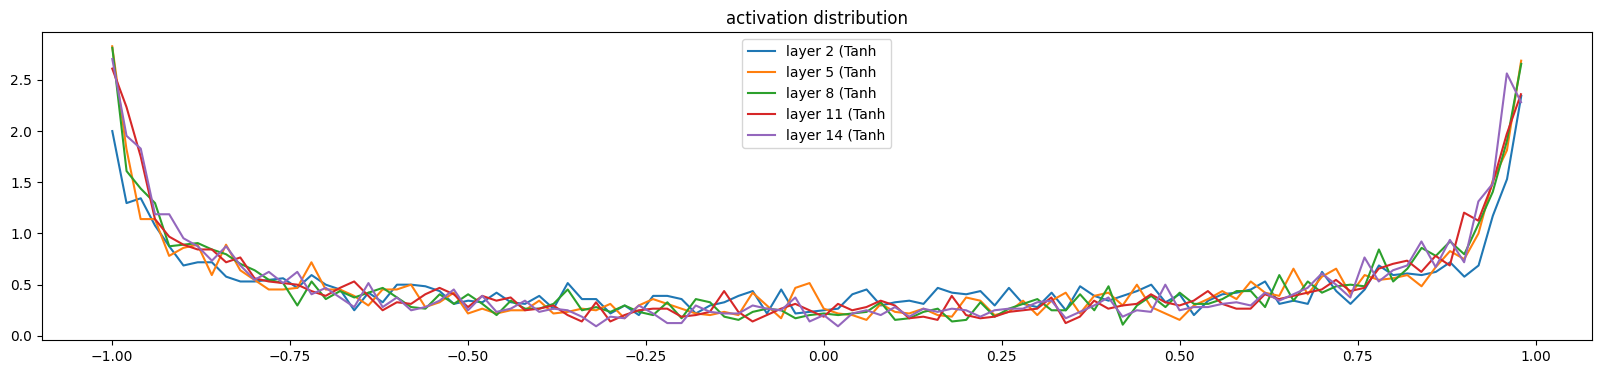

In [136]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.061141e-03
layer 5 (      Tanh): mean +0.000000, std 3.956424e-03
layer 8 (      Tanh): mean +0.000000, std 3.660721e-03
layer 11 (      Tanh): mean -0.000000, std 3.641270e-03
layer 14 (      Tanh): mean +0.000000, std 3.322540e-03


Text(0.5, 1.0, 'gradient distribution')

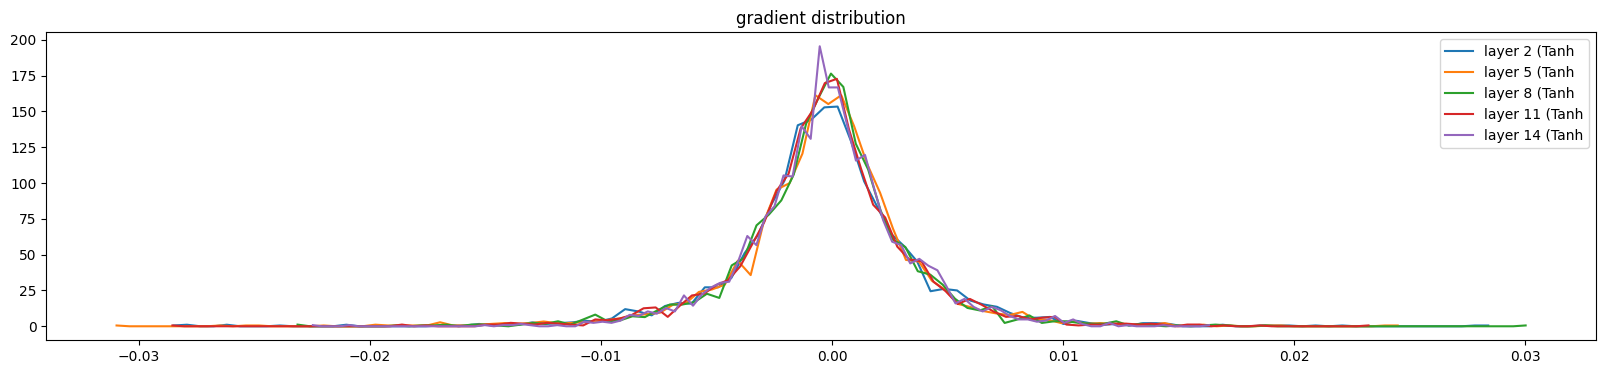

In [137]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.550112e-02 | grad:data ratio 1.366028e-02
weight  (30, 100) | mean +0.000235 | std 8.653337e-03 | grad:data ratio 2.138241e-02
weight (100, 100) | mean -0.000014 | std 5.371959e-03 | grad:data ratio 2.196843e-02
weight (100, 100) | mean -0.000010 | std 5.246487e-03 | grad:data ratio 2.172945e-02
weight (100, 100) | mean +0.000056 | std 5.055566e-03 | grad:data ratio 2.211872e-02
weight (100, 100) | mean -0.000065 | std 4.798275e-03 | grad:data ratio 2.236053e-02
weight  (100, 27) | mean -0.000039 | std 7.612020e-03 | grad:data ratio 2.150643e-02


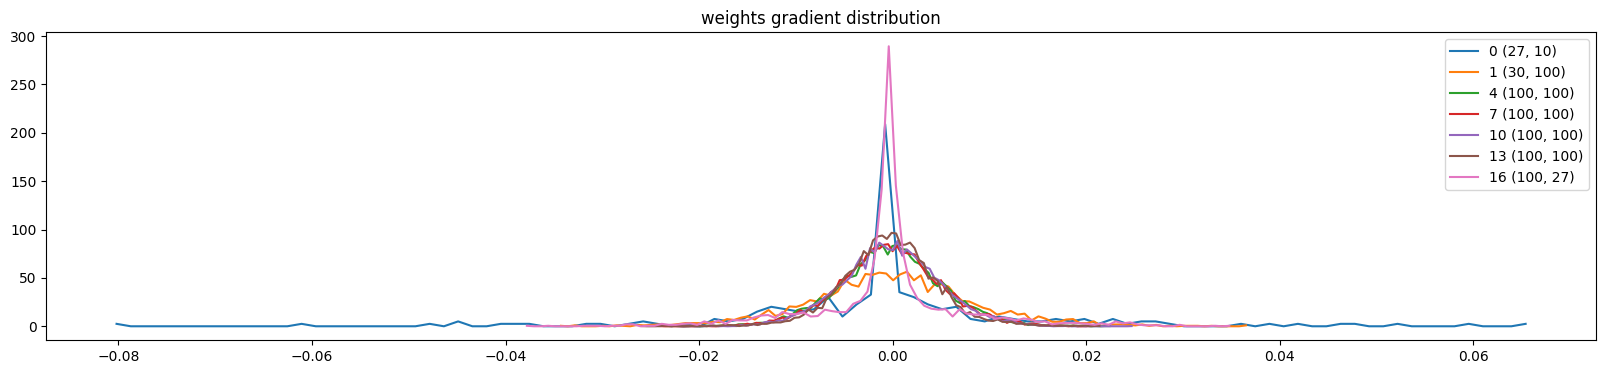

In [127]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

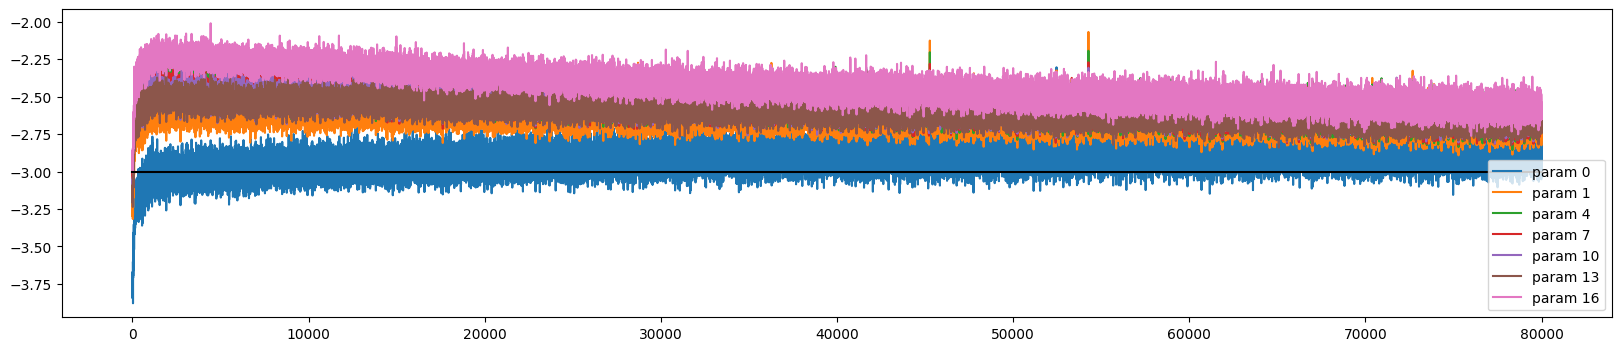

In [138]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [139]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [144]:
layers[0](x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x27 and 30x100)